In [1]:
# Importing libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline


**Example code**

In [2]:
x = torch.linspace(0,799, 800)

In [3]:
y = torch.sin(x*2*3.1416/40)

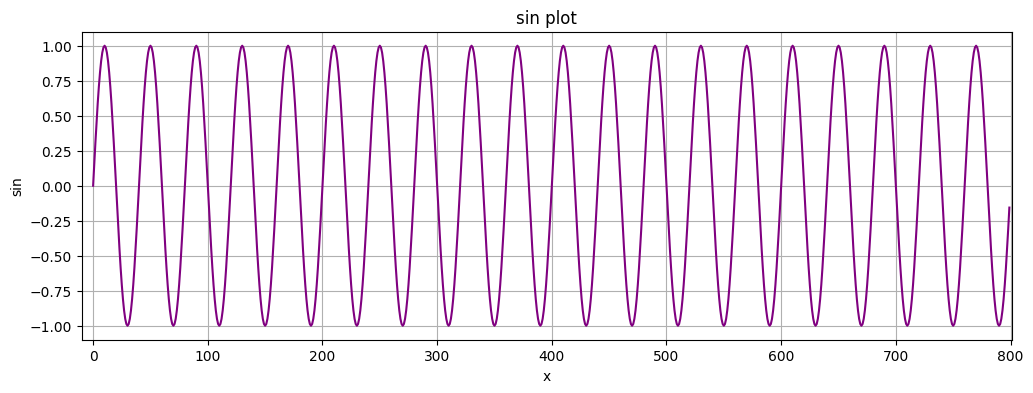

In [4]:
# Plotting
plt.figure(figsize = (12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('sin')
plt.title('sin plot')
plt.plot(y.numpy(), color='purple')
plt.show()

In [5]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

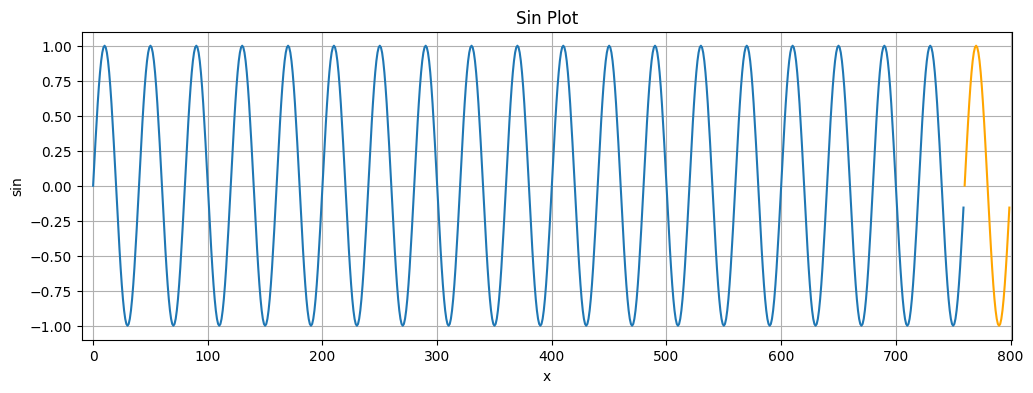

In [6]:
# Plotting the training/testing set
plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('sin')
plt.title('Sin Plot')
plt.plot(train_set.numpy())
plt.plot(range(760,800), test_set.numpy(), color='orange')
plt.show()

**Creating batches**

While working with LSTM models, we divide the training sequence into series of overlapping windows. The label used for comparison is the next value in the sequence.

For example if we have series of of 12 records and a window size of 3, we feed `[x1, x2, x3]` into the model, and compare the prediction to `x4`. Then we backdrop, update parameters, and feed `[x2, x3, x4]` into the model and compare the prediction to `x5`. To ease this process, I'm defining a function `input_data(seq,ws)` that created a list of `(seq,labels)` tuples. If `ws` is the window size, then the total number of `(seq,labels)` tuples will be `len(series)-ws`.

In [7]:
def input_data(seq, ws):
    """
    Generates input-output pairs from a given sequence for training an LSTM model.

    Args:
        seq (list or array-like): The sequence of data from which to extract windows.
        ws (int): The window size, which determines the number of elements in each input sequence.

    Returns:
        list of tuples: A list where each element is a tuple containing:
                        - window (list): A sequence of length 'ws', used as the input for the LSTM.
                        - label (list): The next element in the sequence, which is the label (or output).
    """
    out = []
    L = len(seq)
    
    # Generate input-output pairs by sliding the window across the sequence
    for i in range(L - ws):
        window = seq[i:i + ws]        # Input sequence of length ws
        label = seq[i + ws:i + ws + 1]  # The next element after the window (output label)
        out.append((window, label))    # Append (input, label) pair to the output list
        
    return out

In [8]:
window_size = 40
train_data = input_data(train_set, window_size)
len(train_data)

720

In [9]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [10]:
# Defining the model

class LSTM(nn.Module):
    """
    A simple LSTM model for sequence prediction.

    Args:
        input_size (int): The number of input features. Default is 1.
        hidden_size (int): The number of features in the hidden state. Default is 50.
        output_size (int): The number of output features. Default is 1.
    """
    
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        """
        Initialize the LSTM model with input size, hidden size, and output size.

        Attributes:
            hidden_size (int): Size of the hidden state.
            lstm (nn.LSTM): LSTM layer with input size and hidden size.
            linear (nn.Linear): Linear layer to map LSTM outputs to the desired output size.
            hidden (tuple): Initial hidden and cell states (h_0, c_0) initialized to zeros.
        """
        super().__init__()
        self.hidden_size = hidden_size

        # LSTM layer with specified input size and hidden size
        self.lstm = nn.LSTM(input_size, hidden_size)

        # Linear layer to map from hidden state to output
        self.linear = nn.Linear(hidden_size, output_size)

        # Initialize hidden state (h_0) and cell state (c_0) to zeros
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))

    def forward(self, seq):
        """
        Defines the forward pass of the LSTM model.

        Args:
            seq (torch.Tensor): Input sequence of shape (sequence_length, batch_size, input_size).
        
        Returns:
            torch.Tensor: The output prediction for the last time step.
        """
        # Reshape input sequence for LSTM: (seq_len, batch_size, input_size)
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), -1, 1), self.hidden)

        # Pass LSTM output through the linear layer
        pred = self.linear(lstm_out.view(len(seq), -1))

        # Return the prediction for the last time step
        return pred[-1]

In [11]:
torch.manual_seed(33)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Epoch 0 Loss: 0.08312631398439407
Performance on test range: 0.5938059091567993


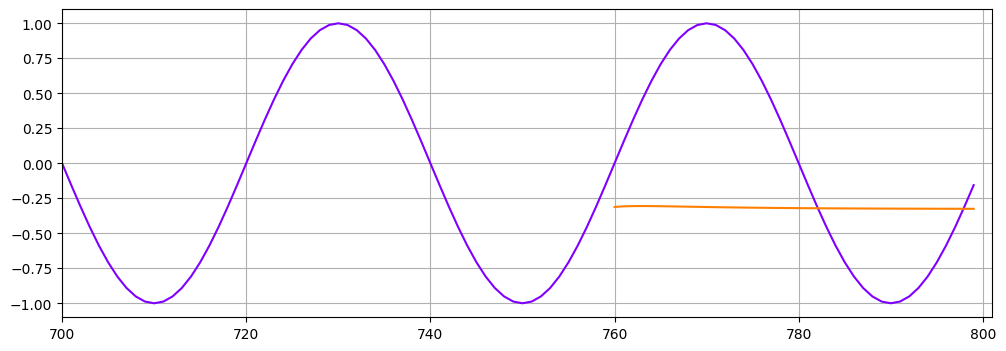

Epoch 1 Loss: 0.04326758533716202
Performance on test range: 0.5082595944404602


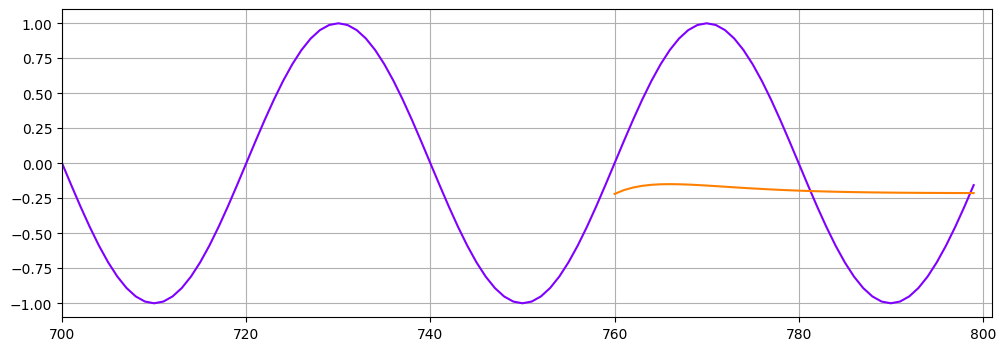

Epoch 2 Loss: 0.00699918856844306
Performance on test range: 0.255395770072937


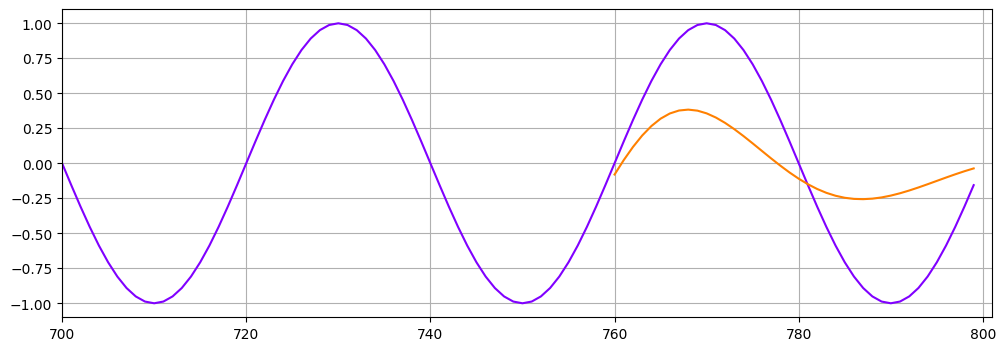

Epoch 3 Loss: 0.00024716369807720184
Performance on test range: 0.018777335062623024


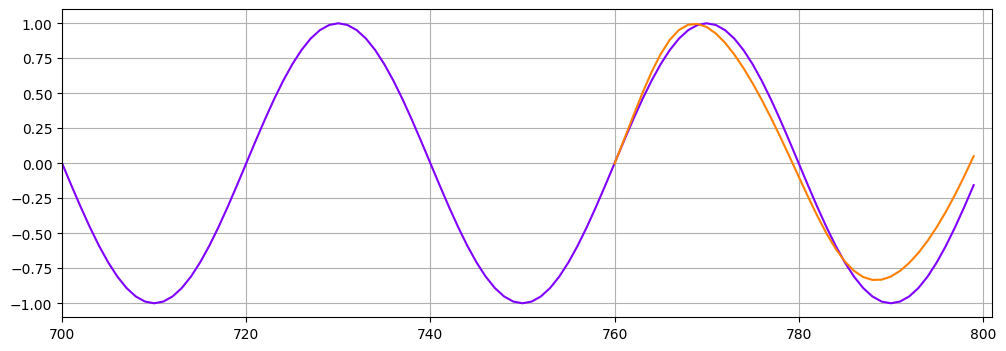

Epoch 4 Loss: 8.002161484910175e-05
Performance on test range: 0.007114785257726908


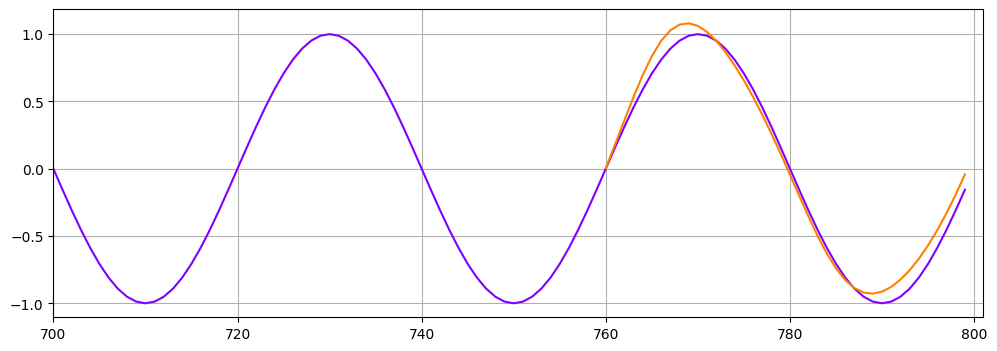

Epoch 5 Loss: 8.245925710070878e-05
Performance on test range: 0.005954197607934475


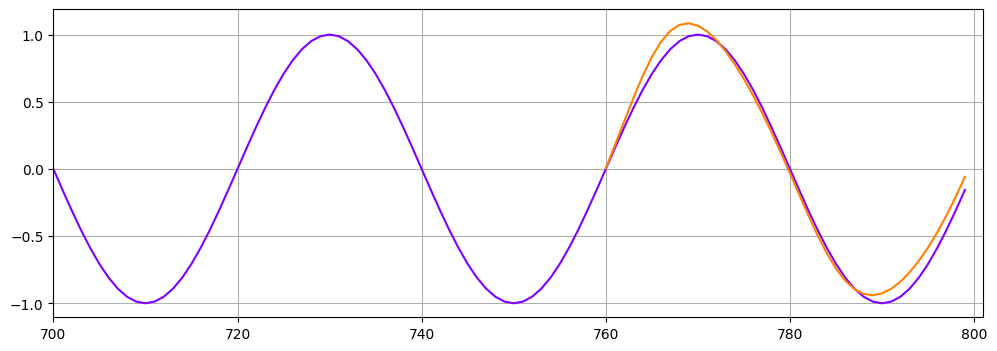

Epoch 6 Loss: 8.970688213594258e-05
Performance on test range: 0.0052449507638812065


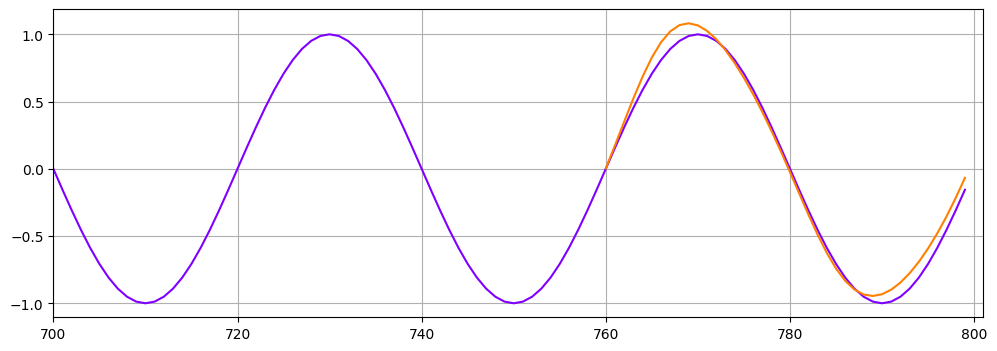

Epoch 7 Loss: 9.479726577410474e-05
Performance on test range: 0.004675266332924366


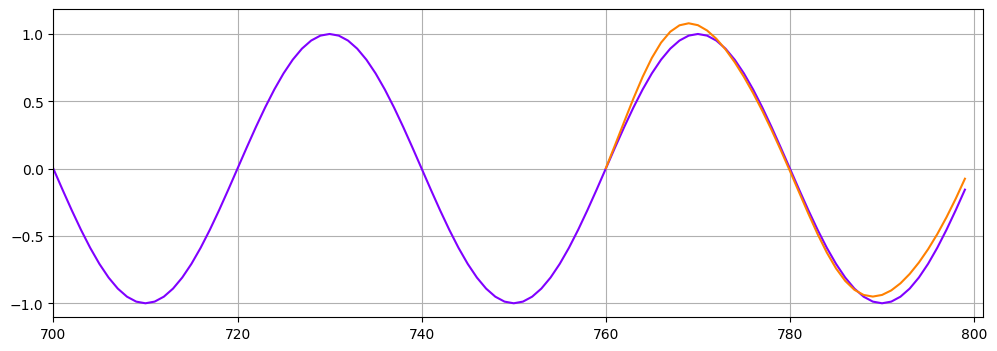

Epoch 8 Loss: 9.775767830433324e-05
Performance on test range: 0.004204418044537306


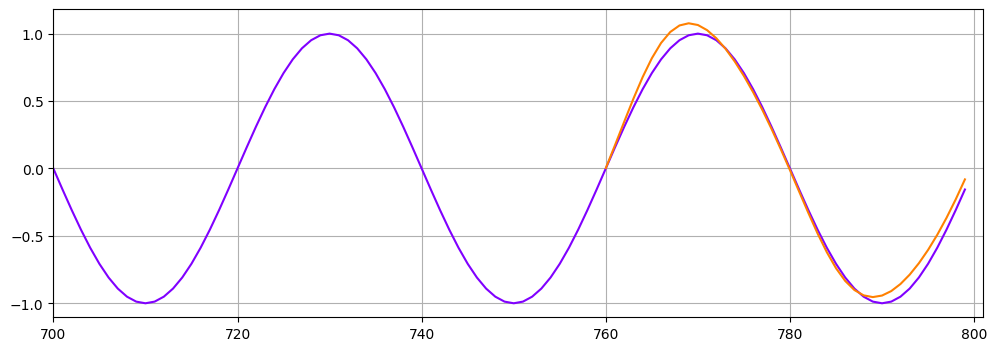

Epoch 9 Loss: 9.902794408844784e-05
Performance on test range: 0.003811374306678772


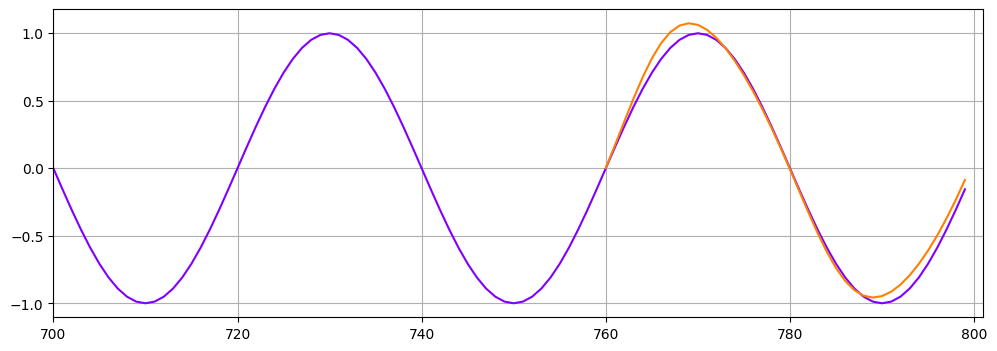

In [13]:
# Training

epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    # visualisation
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()

In [14]:
# Now with the actual data:

df = pd.read_csv("/kaggle/input/for-simple-exercises-time-series-forecasting/Alcohol_Sales.csv", index_col = 0, parse_dates = True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [15]:
df = df.dropna()
len(df)

325

In [16]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

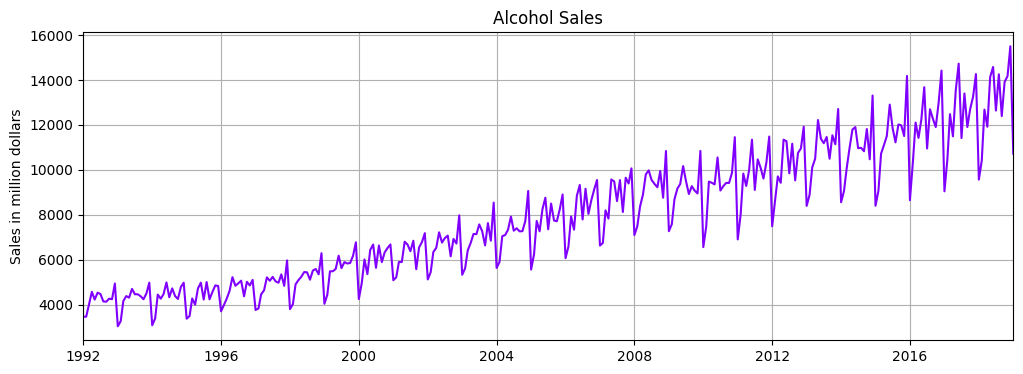

In [17]:
# Plotting
plt.figure(figsize = (12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'],color='#8000ff')
plt.show()

In [18]:
# Preparing and normalizing

y = df['S4248SM144NCEN'].values.astype(float)

test_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [19]:
scaler = MinMaxScaler(feature_range = (-1,1))

train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [20]:
# Converting the training norm into a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# define a window size
window_size = 12

# define a function to create sequence/label tuples
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

#apply input_data to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)

301

In [21]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [22]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [23]:
torch.manual_seed(33)

# instantiate
model = LSTMnetwork()

# loss
criterion = nn.MSELoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [24]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.34929666
Epoch:  2 Loss: 0.29130399
Epoch:  3 Loss: 0.34304586
Epoch:  4 Loss: 0.39694956
Epoch:  5 Loss: 0.32300615
Epoch:  6 Loss: 0.32646191
Epoch:  7 Loss: 0.32269391
Epoch:  8 Loss: 0.32420015
Epoch:  9 Loss: 0.31892264
Epoch: 10 Loss: 0.29906386
Epoch: 11 Loss: 0.29727566
Epoch: 12 Loss: 0.30537227
Epoch: 13 Loss: 0.28830430
Epoch: 14 Loss: 0.28528407
Epoch: 15 Loss: 0.26016828
Epoch: 16 Loss: 0.28083655
Epoch: 17 Loss: 0.28208464
Epoch: 18 Loss: 0.27290347
Epoch: 19 Loss: 0.26242119
Epoch: 20 Loss: 0.26237503
Epoch: 21 Loss: 0.24746732
Epoch: 22 Loss: 0.22689056
Epoch: 23 Loss: 0.23350261
Epoch: 24 Loss: 0.03458368
Epoch: 25 Loss: 0.01505348
Epoch: 26 Loss: 0.07877775
Epoch: 27 Loss: 0.00066097
Epoch: 28 Loss: 0.00077209
Epoch: 29 Loss: 0.00303986
Epoch: 30 Loss: 0.00037048
Epoch: 31 Loss: 0.00000097
Epoch: 32 Loss: 0.00054435
Epoch: 33 Loss: 0.00146124
Epoch: 34 Loss: 0.00126164
Epoch: 35 Loss: 0.00072718
Epoch: 36 Loss: 0.00047068
Epoch: 37 Loss: 0.00047335
E

In [25]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
preds[window_size:]

[0.4101681113243103,
 0.47335198521614075,
 0.5437976121902466,
 0.8033176064491272,
 0.9549356698989868,
 0.43291789293289185,
 0.8122351765632629,
 0.5473636388778687,
 0.6249057650566101,
 0.7932531237602234,
 0.9443889856338501,
 0.26382341980934143]

In [26]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [27]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[11279.77836719],
       [11649.37243752],
       [12061.44413251],
       [13579.50633892],
       [14466.39620107],
       [11412.85321471],
       [13631.66966531],
       [12082.30360562],
       [12535.8862727 ],
       [13520.63414744],
       [14404.70337147],
       [10423.73509417]])

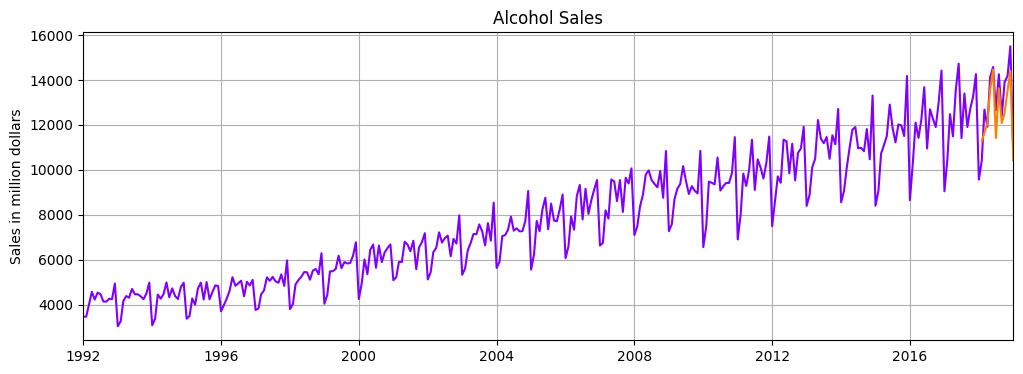

In [28]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()

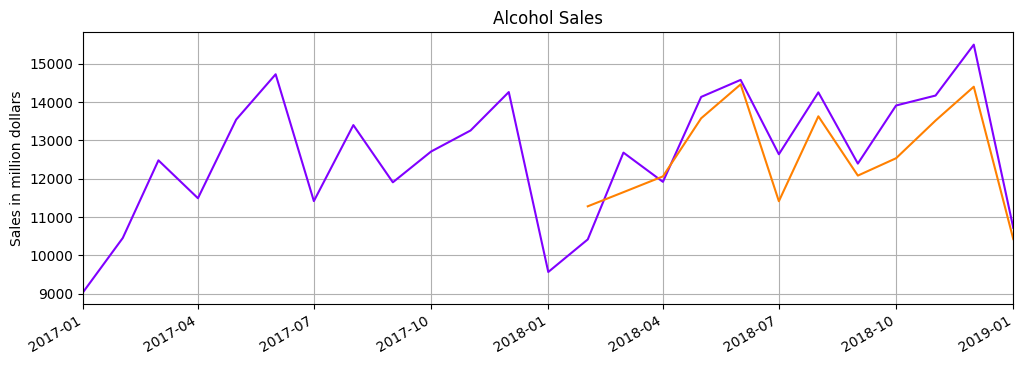

In [29]:
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()